In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    preproc_features,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 1000  # Number of MCMC draws
TUNE = 500  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-01"
reference_end_date = "2024-06-07"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Prior
SECTOR_PRIOR_FILE = Path("data/sector_priors.xml")

# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }

PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Alternative: use a fixed prior strength for all sectors
# PRIOR_STRENGTH = 0.4

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

2025-09-18 11:34:48 | [INFO    ] Found 7 DIC analyses matching criteria


In [3]:
dic_analyses


,dic_id,camera_name,master_timestamp,slave_timestamp,master_image_id,slave_image_id,dt_hours
0,1757,PPCX_Tele,2024-05-29 06:00:18+00:00,2024-06-01 06:00:18+00:00,33995,34018,72
1,1760,PPCX_Tele,2024-05-29 07:00:17+00:00,2024-06-02 07:00:17+00:00,33998,34037,96
2,1763,PPCX_Tele,2024-05-30 10:00:20+00:00,2024-06-03 10:00:18+00:00,34012,34048,96
3,1766,PPCX_Tele,2024-06-01 06:00:18+00:00,2024-06-04 06:00:17+00:00,34018,34060,72
4,1769,PPCX_Tele,2024-06-01 06:00:18+00:00,2024-06-05 06:00:28+00:00,34018,34075,96
5,1772,PPCX_Tele,2024-06-03 05:00:19+00:00,2024-06-06 05:00:19+00:00,34046,34079,72
6,1775,PPCX_Tele,2024-06-03 05:00:19+00:00,2024-06-07 05:00:17+00:00,34046,34096,96


In [4]:
from __future__ import annotations

import contextlib
import json
from collections.abc import Sequence
from dataclasses import dataclass
from pathlib import Path
from typing import Any
from xml.etree import ElementTree as ET

import numpy as np
from matplotlib.path import Path as MplPath
from matplotlib.widgets import PolygonSelector


@dataclass
class Sector:
    """Light wrapper exposing contains_points(x, y)"""

    name: str
    path: MplPath

    def contains_points(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        pts = np.column_stack((x, y))
        return self.path.contains_points(pts)

    def bounds(self) -> tuple[float, float, float, float]:
        verts = np.asarray(self.path.vertices)
        xmin, ymin = verts.min(axis=0)
        xmax, ymax = verts.max(axis=0)
        return float(xmin), float(ymin), float(xmax), float(ymax)

    def plot(self, ax=None, close_polygon: bool = True, **plot_kwargs):
        if ax is None:
            fig, ax = plt.subplots()
        verts = np.asarray(self.path.vertices)
        if close_polygon and not np.allclose(verts[0], verts[-1]):
            verts = np.vstack([verts, verts[0]])
        ax.plot(verts[:, 0], verts[:, 1], **plot_kwargs)
        return ax

    def to_dict(self) -> dict[str, Any]:
        return {"name": self.name, "vertices": self.path.vertices.tolist()}


class MaskDrawer:
    """
    Interactive polygon drawer that does NOT wrap PolygonROISelector.
    Uses matplotlib.widgets.PolygonSelector internally and simple JSON I/O.
    """

    def __init__(self):
        self.polygon_points: list[tuple[float, float]] = []
        self.polygon_path: MplPath | None = None
        self._fig = None
        self._ax = None
        self._selector: PolygonSelector | None = None

    # --- Interactive drawing ---
    def draw(
        self, image=None, save_path: Path | str | None = None, useblit: bool = True
    ):
        """
        Launch interactive polygon drawing. Click to add vertices, press Enter to finish,
        press Escape to cancel. If save_path provided, polygon will be saved on finish.
        Returns list of (x, y) vertices (empty if cancelled).
        """
        if save_path is not None:
            self._save_target = Path(save_path)
        else:
            self._save_target = None

        self._fig, self._ax = plt.subplots(figsize=(10, 8))
        if image is not None:
            self._ax.imshow(image, alpha=0.8)
        self._ax.set_title(
            "Select ROI polygon — Click to add points, press Enter to finish. Press Esc to cancel.",
            fontsize=10,
        )
        self._selector = PolygonSelector(self._ax, self._on_select, useblit=useblit)
        self._fig.canvas.mpl_connect("key_press_event", self._on_key)
        plt.show()
        # after window closed, return stored polygon_points
        return list(self.polygon_points)

    def _on_select(self, verts):
        self.polygon_points = list(verts)
        if len(self.polygon_points) >= 3:
            self.polygon_path = MplPath(self.polygon_points)
        print(f"Polygon updated: {len(self.polygon_points)} vertices")

    def _on_key(self, event):
        if event.key == "enter":
            if len(self.polygon_points) >= 3:
                print("Polygon selection completed")
                if getattr(self, "_save_target", None) is not None:
                    with contextlib.suppress(Exception):
                        self.to_file(self._save_target)
                        print(f"Saved polygon to {self._save_target}")
                with contextlib.suppress(Exception):
                    plt.close(self._fig)
            else:
                print("Need at least 3 points to complete polygon")
        elif event.key == "escape":
            print("Polygon selection cancelled")
            self.polygon_points = []
            self.polygon_path = None
            with contextlib.suppress(Exception):
                plt.close(self._fig)

    # --- I/O helpers ---
    def to_file(self, path: Path | str):
        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        if not path.suffix:
            path = path.with_suffix(".json")
        data = {"polygon_points": self.polygon_points}
        with open(path, "w", encoding="utf-8") as fh:
            json.dump(data, fh)
        return str(path)

    def from_file(self, path: Path | str):
        path = Path(path)
        with open(path, encoding="utf-8") as fh:
            data = json.load(fh)
        pts = data.get("polygon_points", [])
        self.set_polygon(pts)
        return list(self.polygon_points)

    def set_polygon(self, pts: Sequence[tuple[float, float]]):
        self.polygon_points = list(pts)
        if len(self.polygon_points) >= 3:
            self.polygon_path = MplPath(self.polygon_points)
        else:
            self.polygon_path = None

    def clear(self):
        self.polygon_points = []
        self.polygon_path = None

    # --- Conversions ---
    def to_sector(self, name: str) -> Sector | None:
        pts = self.polygon_points
        if not pts or len(pts) < 3:
            return None
        pts_arr = np.asarray(pts, dtype=float)
        verts = np.vstack([pts_arr, pts_arr[0]])
        codes = (
            [MplPath.MOVETO]
            + [MplPath.LINETO] * (len(pts_arr) - 1)
            + [MplPath.CLOSEPOLY]
        )
        path = MplPath(verts, codes)
        return Sector(name=name, path=path)

    @staticmethod
    def sector_from_vertices(
        name: str, verts: Sequence[tuple[float, float]]
    ) -> Sector | None:
        verts_arr = np.asarray(list(verts), dtype=float)
        if verts_arr.shape[0] < 3:
            return None
        closed = np.vstack([verts_arr, verts_arr[0]])
        codes = (
            [MplPath.MOVETO]
            + [MplPath.LINETO] * (len(verts_arr) - 1)
            + [MplPath.CLOSEPOLY]
        )
        path = MplPath(closed, codes)
        return Sector(name=name, path=path)


# CVAT helpers (simple, self-contained)


def read_cvat_xml(xml_source: str | Path) -> ET.Element:
    """
    Read CVAT XML from a file path or from a raw XML string and return the ElementTree root.
    """
    text = None
    try:
        if hasattr(xml_source, "__fspath__") or Path(xml_source).exists():
            with open(xml_source, encoding="utf-8") as fh:
                text = fh.read()
        else:
            text = str(xml_source)
    except Exception:
        text = str(xml_source)
    return ET.fromstring(text)


def _parse_polygon_points(points_str: str) -> np.ndarray:
    """Parse CVAT polygon points string "x1,y1;x2,y2;..." -> (N,2) float ndarray."""
    pts = []
    for p in points_str.split(";"):
        p = p.strip()
        if not p:
            continue
        x_str, y_str = p.split(",")
        pts.append((float(x_str), float(y_str)))
    return np.asarray(pts, dtype=float)


def load_cvat_annotations(xml_source: str | Path) -> dict:
    """
    General CVAT reader that extracts common annotation types per image.

    Returns:
      { image_name: [ (ann_type, label, data, z_order), ... ], ... }

    ann_type is one of: 'polygon', 'polyline', 'points', 'box', 'mask', 'other'.
    - For polygon/polyline/points: data is an (N,2) ndarray from the 'points' attribute.
    - For box: data is dict {'xtl', 'ytl', 'xbr', 'ybr'} (float).
    - For mask: data is the dict produced by parse_mask_element.
    - For unknown types: data is a dict of attributes.
    """
    root = read_cvat_xml(xml_source)
    out: dict = {}
    for img in root.findall(".//image"):
        name = img.get("name")
        items = []
        for element in img:
            tag = element.tag.lower()
            z = int(element.get("z_order", "0") or 0)
            label = element.get("label", "") or ""
            if tag in ("polygon", "polyline", "points"):
                pts_str = element.get("points", "") or ""
                if pts_str:
                    pts_arr = _parse_polygon_points(pts_str)
                else:
                    pts_arr = np.empty((0, 2), dtype=float)
                items.append(("polygon", label, pts_arr, z))
            elif tag == "box":
                try:
                    box = {
                        "xtl": float(element.get("xtl", 0.0)),
                        "ytl": float(element.get("ytl", 0.0)),
                        "xbr": float(element.get("xbr", 0.0)),
                        "ybr": float(element.get("ybr", 0.0)),
                    }
                except Exception:
                    box = {k: element.get(k) for k in ("xtl", "ytl", "xbr", "ybr")}
                items.append(("box", label, box, z))
            elif tag == "mask":
                mask_info = parse_mask_element(element)
                items.append(("mask", mask_info.get("label", label), mask_info, z))
            else:
                # fallback: keep attributes (and text if present)
                data = dict(element.items())
                text = (
                    element.text.strip()
                    if element.text and element.text.strip()
                    else None
                )
                if text is not None:
                    data["_text"] = text
                items.append(("other", label, data, z))
        out[name] = items
    return out


def read_spatial_priors_from_cvat(
    xml_source: str | Path,
    image_name: str | None = None,
    exclude_labels: Sequence[str] | None = None,
) -> list[Sector]:
    """
    Parse polygons from a CVAT export (using load_cvat_annotations) and return a list of Sector objects.

    - If image_name is provided, only polygons for that image are returned.
    - exclude_labels: optional sequence of label names to ignore.
    - polygons are sorted by z_order to preserve annotation stacking order.
    """
    exclude = set(exclude_labels or ())
    parsed = load_cvat_annotations(xml_source)
    if not parsed:
        return []

    if image_name is None:
        try:
            image_name = next(iter(parsed.keys()))
        except StopIteration:
            return []

    items = parsed.get(image_name, [])
    # keep only polygon annotations: items are tuples (ann_type, label, data, z)
    poly_items = [it for it in items if it[0] == "polygon"]
    # sort by z-order (4th element)
    items_sorted = sorted(poly_items, key=lambda it: int(it[3]) if len(it) > 3 else 0)

    sectors: list[Sector] = []
    for _ann_type, label, pts_arr, _z in items_sorted:
        if label in exclude:
            logger.debug("Skipping excluded label: %s", label)
            continue
        if pts_arr is None or getattr(pts_arr, "size", 0) == 0:
            continue
        verts = np.vstack([pts_arr, pts_arr[0]])
        codes = (
            [MplPath.MOVETO]
            + [MplPath.LINETO] * (len(pts_arr) - 1)
            + [MplPath.CLOSEPOLY]
        )
        path = MplPath(verts, codes)
        sectors.append(Sector(name=label or "unnamed", path=path))

    return sectors


def assign_spatial_priors(
    df: pd.DataFrame,
    sectors: dict | Sequence[Any],
    prior_strength: float | None = None,
    sector_prior_probs: dict[str, Sequence[float]] | None = None,
) -> np.ndarray:
    """
    Assign spatial prior probabilities based on polygon sectors.

    Supports two modes:
      - Legacy (sector_prior_probs is None): `sectors` is a sequence and we use
        `prior_strength` to build a simple vector that places mass on the
        sector index (same behaviour as before).
      - New (sector_prior_probs provided): `sectors` can be either a dict
        mapping sector_name -> Sector (or similar) or a sequence of Sector
        objects (must expose .name). `sector_prior_probs` must be a dict
        mapping sector_name -> probability vector (length k). For each point,
        if it falls inside sector_name, the corresponding vector is assigned.

    If a point falls in multiple sectors the last matched sector (iteration
    order) wins. Points not inside any sector receive a uniform prior.
    """
    ndata = len(df)

    # normalize sectors input into ordered list of (name, sector_obj)
    if isinstance(sectors, dict):
        sector_items = list(sectors.items())
    else:
        # assume sequence of Sector-like objects with .name attribute
        sector_items = [
            (getattr(s, "name", f"sector_{i}"), s) for i, s in enumerate(sectors)
        ]

    if sector_prior_probs is not None:
        # Validate keys
        missing = set(name for name, _ in sector_items) - set(sector_prior_probs.keys())
        extra = set(sector_prior_probs.keys()) - set(name for name, _ in sector_items)
        if missing:
            raise ValueError(
                f"assign_spatial_priors: missing prior vectors for sectors: {sorted(missing)}"
            )
        if extra:
            raise ValueError(
                f"assign_spatial_priors: prior_prob entries for unknown sectors: {sorted(extra)}"
            )

        # Determine k and validate vectors
        first_key = next(iter(sector_prior_probs))
        k = len(sector_prior_probs[first_key])
        # build numpy array for each sector (normalized)
        prob_map: dict[str, np.ndarray] = {}
        for name, vec in sector_prior_probs.items():
            arr = np.asarray(vec, dtype=float)
            if arr.ndim != 1:
                raise ValueError(
                    f"assign_spatial_priors: prior vector for '{name}' must be 1D"
                )
            if arr.size != k:
                raise ValueError(
                    f"assign_spatial_priors: inconsistent vector lengths: expected {k}, got {arr.size} for '{name}'"
                )
            s = arr.sum()
            if s <= 0 or np.any(arr < 0):
                raise ValueError(
                    f"assign_spatial_priors: invalid probabilities for '{name}' (must be non-negative and sum>0)"
                )
            prob_map[name] = arr / s
        prior_probs = np.ones((ndata, k), dtype=float) / float(k)  # default uniform
        x = df["x"].values
        y = df["y"].values
        # assign per-sector vectors
        for name, sector in sector_items:
            mask = sector.contains_points(x, y)
            if not np.any(mask):
                logger.info("Sector '%s': 0 points", name)
                continue
            prior_probs[mask, :] = prob_map[name]
            logger.info(f"Sector '{name}': assigned prior to {int(mask.sum())} points")

    # Legacy / fallback behaviour: build simple k-vector per sector index
    elif prior_strength is not None:
        k = len(sector_items)
        if k == 0:
            raise ValueError("assign_spatial_priors: no sectors provided")
        prior_probs = np.ones((ndata, k), dtype=float) / float(k)
        x = df["x"].values
        y = df["y"].values
        for idx, (name, sector) in enumerate(sector_items):
            mask = sector.contains_points(x, y)
            if not np.any(mask):
                logger.info("Sector %s (idx=%d): 0 points", name, idx)
                continue
            if k == 1:
                prior_probs[mask, :] = 1.0
            else:
                other = (1.0 - prior_strength) / float(k - 1)
                vec = np.full(k, other, dtype=float)
                vec[idx] = float(prior_strength)
                prior_probs[mask, :] = vec
            logger.info(
                "Sector %s (idx=%d): %d points with strong prior",
                name,
                idx,
                int(mask.sum()),
            )
    else:
        raise ValueError(
            "assign_spatial_priors: must provide either sector_prior_probs or prior_strength"
        )
    return prior_probs

In [5]:
def parse_mask_element(mask_el: ET.Element) -> dict:
    """
    Parse a single <mask> element from CVAT XML into a dictionary.
    Backwards-compatible helper used by load_cvat_annotations.
    """
    label = mask_el.get("label", "") or ""
    z = int(mask_el.get("z_order", "0") or 0)
    points = mask_el.get("points", None)
    data = None
    if mask_el.text:
        txt = mask_el.text.strip()
        if txt:
            data = txt
    attrs = dict(mask_el.items())
    return {"label": label, "z": z, "points": points, "data": data, "attrs": attrs}


def read_mask_element_from_cvat(
    xml_source: str | Path,
    image_name: str | None = None,
    exclude_labels: Sequence[str] | None = None,
) -> list[dict]:
    """
    Parse <mask> annotations from a CVAT export and return a list of mask info dicts.

    - If image_name is provided, only masks for that image are returned.
    - exclude_labels: optional sequence of label names to ignore.
    - masks are sorted by z_order to preserve annotation stacking order.

    Each returned dict contains at least: 'label', 'z', 'points', 'data', 'attrs'.
    """
    exclude = set(exclude_labels or ())
    parsed = load_cvat_annotations(xml_source)
    if not parsed:
        return []

    if image_name is None:
        try:
            image_name = next(iter(parsed.keys()))
        except StopIteration:
            return []

    items = parsed.get(image_name, [])
    # keep only mask annotations: items are tuples (ann_type, label, data, z)
    mask_items = [it for it in items if it[0] == "mask"]
    # sort by z-order (4th element)
    items_sorted = sorted(mask_items, key=lambda it: int(it[3]) if len(it) > 3 else 0)

    masks: list[dict] = []
    for _ann_type, label, mask_info, _z in items_sorted:
        if label in exclude:
            logger.debug("Skipping excluded mask label: %s", label)
            continue
        # mask_info is expected to be a dict produced by parse_mask_element
        if isinstance(mask_info, dict):
            info = dict(mask_info)  # copy to avoid mutating originals
        else:
            # fallback: preserve raw data
            info = {
                "label": label or "",
                "data": mask_info,
                "attrs": {},
                "points": None,
                "z": 0,
            }

        # ensure canonical keys
        info["label"] = info.get("label", label or "")
        info["z"] = int(info.get("z", 0) or 0)
        info.setdefault("points", None)
        info.setdefault("data", None)
        info.setdefault("attrs", {})

        masks.append(info)

    return masks


def filter_dataframe_by_masks(
    xml_source: str | Path,
    df: pd.DataFrame,
    x_col: str = "x",
    y_col: str = "y",
    exclude_labels: Sequence[str] | None = None,
) -> pd.DataFrame:
    """
    Filter dataframe using polygonal <mask> annotations from a CVAT XML.

    - If no masks are present in the CVAT file, the original dataframe is returned unchanged.
    - If masks are present, points are kept if they fall in the union of mask polygons.
    - exclude_labels can be used to ignore masks by label.
    """
    exclude = set(exclude_labels or ())
    masks = read_mask_element_from_cvat(
        xml_source, image_name=None, exclude_labels=exclude
    )
    if not masks:
        logger.info(
            "No CVAT masks found at %s — skipping CVAT mask filtering", xml_source
        )
        return df

    x_vals = df[x_col].to_numpy()
    y_vals = df[y_col].to_numpy()
    pts_xy = np.column_stack((x_vals, y_vals))
    include_mask = np.zeros(len(df), dtype=bool)

    for mask_info in masks:
        label = mask_info.get("label", "")
        pts_str = mask_info.get("points", None)
        if not pts_str:
            logger.debug("Mask '%s' has no 'points' attribute; skipping", label)
            continue
        try:
            verts = _parse_polygon_points(pts_str)  # (N,2)
            if verts.shape[0] < 3:
                logger.debug("Mask '%s' has fewer than 3 vertices; skipping", label)
                continue
            # ensure closed polygon for MplPath.contains_points behaviour
            if not np.allclose(verts[0], verts[-1]):
                verts = np.vstack([verts, verts[0]])
            path = MplPath(verts)
            hit = path.contains_points(pts_xy)
            include_mask |= hit
            logger.info("Mask '%s': %d points inside", label, int(hit.sum()))
        except Exception as exc:
            logger.warning("Failed to parse/apply mask '%s': %s", label, exc)
            continue

    df_filtered = df.loc[include_mask].reset_index(drop=True)
    logger.info("Data shape after CVAT mask filtering: %s", df_filtered.shape)
    return df_filtered


In [6]:
# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
filter_kwargs = dict(
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    apply_2d_median=config.get("dic.apply_2d_median"),
    median_window_size=config.get("dic.median_window_size"),
    median_threshold_factor=config.get("dic.median_threshold_factor"),
    apply_2d_gaussian=config.get("dic.apply_2d_gaussian", True),
    gaussian_sigma=config.get("dic.gaussian_sigma", 1.0),
)
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1757 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1760 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1763 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1766 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1769 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1772 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Fetched DIC data for id 1775 with 3927 points
2025-09-18 11:34:49 | [INFO    ] Found stack of 7 DIC dataframes. Run filtering...
2025-09-18 11:34:49 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-18 11:34:49 | [INFO    ] Percentile filtering: 3927 -> 3847 points (removed 80 outliers)
2025-09-18 11:34:49 | [INFO    ] Min velocity filtering: 3847 -> 2481 points (removed 1366 points below 1)
2025-09-18 11:34:49 | [INFO    ] Applying 2D median filter (u,v,V): window_siz

In [7]:
# Apply ROI filter
# selector = PolygonROISelector.from_file(config.get("data.roi_path"))
# df = selector.filter_dataframe(df, x_col="x", y_col="y")
# df2 = filter_dataframe_by_masks(SECTOR_PRIOR_FILE, df, x_col="x", y_col="y")
# logger.info(f"Data shape after filtering: {df2.shape}")


In [8]:
# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")
df_features = preproc_features(df)
X = df_features[variables_names].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-18 11:34:56 | [INFO    ] Data shape after subsampling: (13963, 5)
2025-09-18 11:34:56 | [INFO    ] Using features: ['V']
2025-09-18 11:34:56 | [INFO    ] Feature matrix shape: (13963, 1)


Filtered 15612 points to 13963 points inside polygon
Subsampled from 13963 to 13963 points (100.0%)


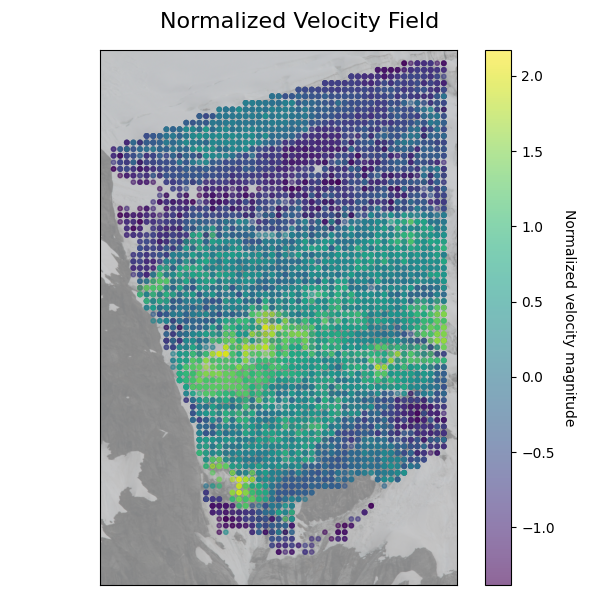

In [9]:
# Plot normalized velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("Normalized Velocity Field", fontsize=16)
ax.imshow(img, alpha=0.5, cmap="gray")
norm = plt.Normalize(vmin=X_scaled.min(), vmax=X_scaled.max())
q = ax.scatter(
    df_features["x"].to_numpy(),
    df_features["y"].to_numpy(),
    c=X_scaled,
    cmap="viridis",
    norm=norm,
    s=10,
    alpha=0.6,
)
cbar = fig.colorbar(q, ax=ax)
cbar.set_label("Normalized velocity magnitude", rotation=270, labelpad=15)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
# Assign spatial priors to points
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)
prior_probs = assign_spatial_priors(df, sectors, sector_prior_probs=PRIOR_PROBABILITY)
# plot_spatial_priors(df, prior_probs, img=img);

2025-09-18 11:34:58 | [INFO    ] Sector 'A': assigned prior to 987 points
2025-09-18 11:34:58 | [INFO    ] Sector 'B': assigned prior to 3895 points
2025-09-18 11:34:58 | [INFO    ] Sector 'C': assigned prior to 4437 points


In [11]:
# # Simple, not marginalized model (z discrete) --> slower sampling, but direct cluster assignments

# n_features = X_scaled.shape[1]
# n_data = X_scaled.shape[0]
# k = len(sectors)  # number of clusters = number of sectors
#
# with pm.Model(
#     coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
# ) as simple_model:
#     # Cluster means
#     μ = pm.Normal("μ", mu=0, sigma=1, dims=("cluster", "feature"))

#     # Cluster standard deviations (diagonal covariance)
#     σ = pm.HalfNormal("σ", sigma=0.5, dims=("cluster", "feature"))

#     # Cluster assignments with spatial priors
#     z = pm.Categorical("z", p=prior_probs, dims="obs")

#     # Likelihood: each point comes from its assigned cluster
#     observations = pm.Normal(
#         "x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature")
#     )

# with simple_model:
#     prior_samples = pm.sample_prior_predictive(100)

# fig, ax = plt.subplots(figsize=(8, 4))
# az.plot_dist(
#     X_scaled,
#     kind="hist",
#     color="C1",
#     hist_kwargs={"alpha": 0.6},
#     label="observed",
# )
# az.plot_dist(
#     prior_samples.prior_predictive["x_obs"],
#     kind="hist",
#     hist_kwargs={"alpha": 0.6},
#     label="simulated",
# )
# plt.xticks(rotation=45);

In [12]:
# Marginalized mixture model (no discrete z) --> faster sampling, but no direct cluster assignments
n_features = X_scaled.shape[1]
n_data = X_scaled.shape[0]
k = len(sectors)  # number of clusters = number of sectors

with pm.Model(
    coords={"obs": range(n_data), "cluster": range(k), "feature": range(n_features)}
) as model:
    obs_data = pm.Data("obs_data", X_scaled, dims=("obs", "feature"))
    prior_w = pm.Data(
        "prior_w", prior_probs.reshape(n_data, k), dims=("obs", "cluster")
    )

    mu = pm.Normal("mu", 0, 1, dims=("cluster", "feature"))
    sigma = pm.HalfNormal("sigma", 0.5, dims=("cluster", "feature"))

    # Log weights with small constant to avoid log(0)
    log_w = pm.Deterministic(
        "log_w", pm.math.log(prior_w + 1e-12), dims=("obs", "cluster")
    )

    # Per-cluster log-likelihood
    x_centered = (obs_data[:, None, :] - mu[None, :, :]) / sigma[None, :, :]
    logp_feat = -0.5 * (
        pm.math.log(2 * np.pi) + 2 * pm.math.log(sigma[None, :, :]) + x_centered**2
    )
    logp_clusters = logp_feat.sum(axis=2)  # (obs, cluster)

    # Mixture log likelihood (marginalized over clusters)
    log_mix = pm.logsumexp(logp_clusters + log_w, axis=1)  # (obs,)

    # Total logp as Potential
    pm.Potential("mixture_logp", log_mix.sum())

logger.info("Marginalized mixture model created (no discrete z).")


2025-09-18 11:35:00 | [INFO    ] Marginalized mixture model created (no discrete z).


In [ ]:
# Sampling (now NUTS can be used for mu, sigma)
posterior_path = output_dir / f"{base_name}_posterior.idata.nc"
if LOAD_EXISTING is False or not posterior_path.exists():
    with model:
        logger.info("Starting MCMC sampling...")
        idata = pm.sample(
            target_accept=TARGET_ACCEPT,
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            cores=CORES,
            random_seed=RANDOM_SEED,
        )
    logger.info("Sampling completed!")

    # save the posterior InferenceData object and the scaler
    if SAVE_OUTPUTS:
        az.to_netcdf(idata, posterior_path)
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
        logger.info(f"Outputs saved to {output_dir}")
else:
    logger.info("Loading existing posterior InferenceData object...")
    idata = az.from_netcdf(posterior_path)

2025-09-18 11:35:00 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


In [ ]:
print(az.summary(idata, var_names=["mu", "sigma"]))

In [ ]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["mu", "sigma"], axes=axes, compact=True, legend=True)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)

In [ ]:
az.plot_forest(idata, var_names=["mu", "sigma"], combined=True, ess=True);

In [ ]:
## === POSTERIOR ANALYSIS: ASSIGN POINTS TO CLUSTERS ===

# compute cluster assignments (subsample 200 posterior draws to save time)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, n_posterior_samples=200
)
fig, uncertainty, stats = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")